# Instacart Market Basket Analysis with SQL (SQlite3)
Which products will an Instacart consumer purchase again?


Data for this project is downloaded from
https://www.kaggle.com/c/instacart-market-basket-analysis/data



In [1]:
#Load necessary modules
import warnings
warnings.filterwarnings('ignore') # silence annoying warningsn
#sqlalchemy used so latter would be easy to convert from sqlite to postgress or other databases
from sqlalchemy import create_engine
import sqlite3 as sql
from datetime import datetime


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#List provided data files
import os
print (os.getcwd())


C:\Users\dave_\Documents\instacart_kaggle


In [3]:
#run this 877304308503853 before, so dont need to extract again
#UnZip files
#import zipfile
#with zipfile.ZipFile("aisles.csv.zip","r") as zip_ref:
#    zip_ref.extractall("../instacart_shopping_analytics/data")
#with zipfile.ZipFile("departments.csv.zip","r") as zip_ref:
#    zip_ref.extractall("../instacart_shopping_analytics/data")
#with zipfile.ZipFile("orders.csv.zip","r") as zip_ref:
#    zip_ref.extractall("../instacart_shopping_analytics/data")
#with zipfile.ZipFile("order_products__prior.csv.zip","r") as zip_ref:
#    zip_ref.extractall("../instacart_shopping_analytics/data")
#with zipfile.ZipFile("order_products__train.csv.zip","r") as zip_ref:
#    zip_ref.extractall("../instacart_shopping_analytics/data")
#with zipfile.ZipFile("products.csv.zip","r") as zip_ref:
#    zip_ref.extractall("../instacart_shopping_analytics/data")
#with zipfile.ZipFile("sample_submission.csv.zip","r") as zip_ref:
#    zip_ref.extractall("../instacart_shopping_analytics/data")    



In [3]:
print (os.getcwd())
data_path="../instacart_kaggle/data"
os.chdir(data_path)
data_output="../"
print (os.getcwd())
os.chdir(data_path)
print ("change of working directory \n")
print (os.getcwd())

C:\Users\dave_\Documents\instacart_kaggle
C:\Users\dave_\Documents\instacart_kaggle\data


FileNotFoundError: [WinError 3] The system cannot find the path specified: '../instacart_kaggle/data'

In [4]:
#print the list of csv files in the input folder
#The subprocess module allows you to spawn new processes, connect to their input/output/error pipes,
#and obtain their return codes
from subprocess import check_output

conn = create_engine('sqlite:///kaggle_instakart.db')

## Files loading into SQlite chunk by chunk
Let's read all files into SQlite


In [5]:
# Links orders to products


#FUNCTION read_chunk_to_sqlite
def read_chunk_csv_to_sqlite(file_name,disk_engine, table):
    #to time loading process
    start = datetime.now()
    #chunk_size - number of rows
    chunk_size = 10000
    i = 0
    index_start = 1
    drop_table="DROP TABLE IF EXISTS %s ;" %(table)
    conn.execute(drop_table)        
    
    for df in pd.read_csv(file_name, chunksize=chunk_size, iterator=True, encoding='utf-8'):
        df = df.rename(columns={c: c.replace(' ', '') for c in df.columns}) # delete spaces between columns from CSV file
        df.index += index_start
        i+=1
        if i<= 50:
            df.to_sql(table, disk_engine, if_exists='append')
            if i%10 == 0:
                #print how long it takes to load database
                print ('{} Seconds: Loaded rows {}'.format((datetime.now()-start).total_seconds(),i*chunk_size))
            index_start = df.index[-1] + 1
        else:
            print("Limit Data for exploration")
            break
    
    # Created indexes on all id columns. this is a life saver
    index_columns = [col for col in df.columns if col.find("_id")>-1]
    for col in index_columns:
        #create indexes for latter for quicker access
        create_indexes="CREATE INDEX index_%s on %s (%s);" %(col+"_"+table,table,col)
        conn.execute(create_indexes)        


In [6]:
# Read CSV into SQLite database
print (os.getcwd())
files_list = [file  for file in os.listdir() if file.find(".csv") != -1 ]
#files_list = [file  for file in os.listdir(data_path) if file.find(".csv") != -1 ]
print (files_list)


C:\Users\dave_\Documents\instacart_kaggle\data
['aisles.csv', 'departments.csv', 'orders.csv', 'order_products__prior.csv', 'order_products__train.csv', 'products.csv', 'sample_submission.csv']


In [7]:
for file in files_list:    
    table = file.split(".")[0]
    print('\n loading table {}'.format(table))
    file_name = file
  #  file_name = data_path + "/"+file
    #print(filename)
    read_chunk_csv_to_sqlite(file_name,conn,table)
    print (' loading of table {} complete'.format(table))


 loading table aisles
 loading of table aisles complete

 loading table departments
 loading of table departments complete

 loading table orders
10.63877 Seconds: Loaded rows 100000
14.467605 Seconds: Loaded rows 200000
18.400502 Seconds: Loaded rows 300000
22.687856 Seconds: Loaded rows 400000
26.471691 Seconds: Loaded rows 500000
Limit Data for exploration
 loading of table orders complete

 loading table order_products__prior
7.295414 Seconds: Loaded rows 100000
11.106118 Seconds: Loaded rows 200000
14.598265 Seconds: Loaded rows 300000
17.927341 Seconds: Loaded rows 400000
21.401197 Seconds: Loaded rows 500000
Limit Data for exploration
 loading of table order_products__prior complete

 loading table order_products__train
8.233431 Seconds: Loaded rows 100000
11.971737 Seconds: Loaded rows 200000
15.277058 Seconds: Loaded rows 300000
18.460617 Seconds: Loaded rows 400000
21.832954 Seconds: Loaded rows 500000
Limit Data for exploration
 loading of table order_products__train comple

## First look into loaded tables

In [8]:
#EXPLORING AISLES
aisles = pd.read_sql_query("SELECT * FROM aisles LIMIT 5 ;", conn)
print('Total number of aisles: {}'.format(aisles.shape[0]))
print("Top 5 in aisles table\n",aisles.head(),"\n\n")

Total number of aisles: 5
Top 5 in aisles table
    index  aisle_id                       aisle
0      1         1       prepared soups salads
1      2         2           specialty cheeses
2      3         3         energy granola bars
3      4         4               instant foods
4      5         5  marinades meat preparation 




In [9]:
#EXPLORING DEPARTMENTS
departments = pd.read_sql_query("SELECT * FROM departments LIMIT 5 ;", conn)
print('Total number of departments: {}'.format(departments.shape[0]))
print("Top 5 in departments table\n",departments.head(),"\n\n")

Total number of departments: 5
Top 5 in departments table
    index  department_id department
0      1              1     frozen
1      2              2      other
2      3              3     bakery
3      4              4    produce
4      5              5    alcohol 




In [10]:
#EXPLORING PRODUCTS
products = pd.read_sql_query("SELECT * FROM products LIMIT 5 ;", conn)
print('Total number of products: {}'.format(products.shape[0]))
print("Top 5 in products table\n",products.head(),"\n\n")

Total number of products: 5
Top 5 in products table
    index  product_id                                       product_name  \
0      1           1                         Chocolate Sandwich Cookies   
1      2           2                                   All-Seasons Salt   
2      3           3               Robust Golden Unsweetened Oolong Tea   
3      4           4  Smart Ones Classic Favorites Mini Rigatoni Wit...   
4      5           5                          Green Chile Anytime Sauce   

   aisle_id  department_id  
0        61             19  
1       104             13  
2        94              7  
3        38              1  
4         5             13   




In [11]:
#EXPLORING ORDERS
orders = pd.read_sql_query("SELECT * FROM orders LIMIT 5 ;", conn)
print('Total number of orders: {}'.format(orders.shape[0]))
print("Top 5 in orders table\n",orders.head(),"\n\n")

Total number of orders: 5
Top 5 in orders table
    index  order_id  user_id eval_set  order_number  order_dow  \
0      1   2539329        1    prior             1          2   
1      2   2398795        1    prior             2          3   
2      3    473747        1    prior             3          3   
3      4   2254736        1    prior             4          4   
4      5    431534        1    prior             5          4   

   order_hour_of_day  days_since_prior_order  
0                  8                     NaN  
1                  7                    15.0  
2                 12                    21.0  
3                  7                    29.0  
4                 15                    28.0   




In [12]:
#EXPLORE MORE ORDERS TRAIN DATASET
count_orders = pd.read_sql_query("SELECT COUNT (order_id) FROM orders ;", conn)
#print('Total number of orders prior: {}'.format(orders_prior.shape[0]))
print("Count orders train table\n",count_orders,"\n\n")

Count orders train table
    COUNT (order_id)
0            500000 




In [13]:
#EXPLORE MORE ORDERS 
count_orders_test = pd.read_sql_query("SELECT COUNT (user_id) FROM orders WHERE eval_set='test' ;", conn)
#print('Total number of orders prior: {}'.format(orders_prior.shape[0]))
print("Count orders test table\n",count_orders_test,"\n\n")
count_orders_train = pd.read_sql_query("SELECT COUNT (user_id) FROM orders WHERE eval_set='train' ;", conn)
#print('Total number of orders prior: {}'.format(orders_prior.shape[0]))
print("Count orders train table\n",count_orders_train,"\n\n")
count_orders_prior = pd.read_sql_query("SELECT COUNT (user_id) FROM orders WHERE eval_set='prior' ;", conn)
#print('Total number of orders prior: {}'.format(orders_prior.shape[0]))
print("Count orders prior table\n",count_orders_prior,"\n\n")

Count orders test table
    COUNT (user_id)
0            10931 


Count orders train table
    COUNT (user_id)
0            19216 


Count orders prior table
    COUNT (user_id)
0           469853 




Ok, we need only to predict which products will be reordered for only 10931 user_id

In [14]:
#EXPLORING ORDERS TRAIN
orders_train = pd.read_sql_query("SELECT * FROM order_products__train LIMIT 5 ;", conn)
print('Total number of orders train: {}'.format(orders_train.shape[0]))
print("Top 5 in orders train table\n",orders_train,"\n\n")

Total number of orders train: 5
Top 5 in orders train table
    index  order_id  product_id  add_to_cart_order  reordered
0      1         1       49302                  1          1
1      2         1       11109                  2          1
2      3         1       10246                  3          0
3      4         1       49683                  4          0
4      5         1       43633                  5          1 




In [15]:
#EXPLORE MORE ORDERS TRAIN DATASET MORE QC
count_train = pd.read_sql_query("SELECT COUNT (product_id) FROM order_products__train ;", conn)
#print('Total number of orders prior: {}'.format(orders_prior.shape[0]))
print("Count orders train table\n",count_train,"\n\n")

Count orders train table
    COUNT (product_id)
0              500000 




In [16]:
#EXPLORING ORDERS PRIOR
orders_prior = pd.read_sql_query("SELECT * FROM order_products__prior LIMIT 5 ;", conn)
print('Total number of orders prior: {}'.format(orders_prior.shape[0]))
print("Top 5 in orders prior table\n",orders_prior.head(),"\n\n")

Total number of orders prior: 5
Top 5 in orders prior table
    index  order_id  product_id  add_to_cart_order  reordered
0      1         2       33120                  1          1
1      2         2       28985                  2          1
2      3         2        9327                  3          0
3      4         2       45918                  4          1
4      5         2       30035                  5          0 




In [17]:
#EXPLORE MORE PRIOR DATASET  MORE QC
count_prior = pd.read_sql_query("SELECT COUNT (order_id) FROM order_products__prior ;", conn)
#print('Total number of orders prior: {}'.format(orders_prior.shape[0]))
print("Count orders prior table\n",count_prior,"\n\n")

Count orders prior table
    COUNT (order_id)
0            500000 




In [18]:
#ALL LOADED SUCCESFULLY, CAN DELETE TEMPORARY DataFrames
del aisles,departments,products,orders,orders_train,orders_prior

## Creation of combined tables


First, I will create "productscombined" table, which will be a combination of department, aisle and products, so I have 
all products information in one table.

In [19]:
#merge tables department, aisle, products and call it productscombined

#add a time counter, how long it takes to create a table
start_time1 = datetime.now()
drop_productscombined_table=""" DROP TABLE IF EXISTS productscombined;"""
conn.execute(drop_productscombined_table)
joinprod_sql = """\
    CREATE TABLE productscombined AS
    SELECT p.*, d.department, a.aisle
    FROM products p
    INNER JOIN departments d ON p.department_id = d.department_id
    INNER JOIN aisles a ON p.aisle_id = a.aisle_id;
    """
conn.execute(joinprod_sql)
#TO QC what we loaded, first 5 rows
productscombined_qc = pd.read_sql_query("SELECT * FROM productscombined Limit 5;", conn)
end_time1 = datetime.now()
print('\nTime for productscombined {}\n'.format((end_time1-start_time1).total_seconds()))
print("Top5_productscombined \n", productscombined_qc.head(),"\n\n")

count_merge1 = pd.read_sql_query("SELECT COUNT (product_id) FROM productscombined ;", conn)
#print('Total number of orders prior: {}'.format(orders_prior.shape[0]))
print("Number of products in database \n",count_merge1,"\n\n")


Time for productscombined 0.749714

Top5_productscombined 
    index  product_id                                       product_name  \
0      1           1                         Chocolate Sandwich Cookies   
1      2           2                                   All-Seasons Salt   
2      3           3               Robust Golden Unsweetened Oolong Tea   
3      4           4  Smart Ones Classic Favorites Mini Rigatoni Wit...   
4      5           5                          Green Chile Anytime Sauce   

   aisle_id  department_id department                       aisle  
0        61             19     snacks               cookies cakes  
1       104             13     pantry           spices seasonings  
2        94              7  beverages                         tea  
3        38              1     frozen                frozen meals  
4         5             13     pantry  marinades meat preparation   


Number of products in database 
    COUNT (product_id)
0               49688 

Secondly, I will create a table orderscombined which will be a combination of
order_products_prior and orders.


In [20]:
#Combine orders and the orders_prior dataframe

start_time2 = datetime.now()
drop_orderscombined1_table=""" DROP TABLE IF EXISTS orderscombined1;"""
conn.execute(drop_orderscombined1_table)
joinordersprior_sql1 = """\
    CREATE TABLE orderscombined1 AS
    SELECT o.*, op.product_id, op.add_to_cart_order,op.reordered
    FROM orders o
    INNER JOIN order_products__prior op ON o.order_id = op.order_id;
    """



conn.execute(joinordersprior_sql1)
#QC what has been loaded in SQL
orderscombined1 = pd.read_sql_query("SELECT * FROM orderscombined1 Limit 5;", conn)

#create indexes to make life easier latter and do requests much faster
indexcolumns = [col for col in orderscombined1.columns if col.find("_id")>-1]
for col in indexcolumns:
    createindexes="CREATE INDEX index_%s ON orderscombined1 (%s);" %(col+"_orderscombined1",col)
    conn.execute(createindexes)         
        
end_time2 = datetime.now()
print('\nTime for orderscombined1 {}\n'.format((end_time2-start_time2).total_seconds()))
print("Top5_orderscombined1 Table \n", orderscombined1.head(),"\n\n")

count_merge1 = pd.read_sql_query("SELECT COUNT (product_id) FROM orderscombined1 ;", conn)
#print('Total number of orders prior: {}'.format(orders_prior.shape[0]))
print("Total number of products in orders in database \n",count_merge1,"\n\n")


Time for orderscombined1 1.89819

Top5_orderscombined1 Table 
    index  order_id  user_id eval_set  order_number  order_dow  \
0     71     23391        7    prior            17          0   
1     71     23391        7    prior            17          0   
2     71     23391        7    prior            17          0   
3     71     23391        7    prior            17          0   
4     71     23391        7    prior            17          0   

   order_hour_of_day  days_since_prior_order  product_id  add_to_cart_order  \
0                 10                    28.0       13198                  1   
1                 10                    28.0       42803                  2   
2                 10                    28.0        8277                  3   
3                 10                    28.0       37602                  4   
4                 10                    28.0       40852                  5   

   reordered  
0          1  
1          1  
2          1  
3         

Only 72909 product_id have mathing records in both tables orders and orders_prior


In [21]:
#Combine orders and the order_products__train dataframe


start_time3 = datetime.now()
drop_orderscombined2_table=""" DROP TABLE IF EXISTS orderscombined2;"""
conn.execute(drop_orderscombined2_table)
joinordersprior_sql2 = """\
    CREATE TABLE orderscombined2 AS
    SELECT o.*, op.product_id, op.add_to_cart_order,op.reordered
    FROM orders o
    INNER JOIN order_products__train op ON o.order_id = op.order_id;
    """

conn.execute(joinordersprior_sql2)
#QC what has been loaded in SQL
orderscombined2 = pd.read_sql_query("SELECT * FROM orderscombined2 Limit 5;", conn)

#create indexes to make life easier latter and do requests much faster
indexcolumns = [col for col in orderscombined2.columns if col.find("_id")>-1]
for col in indexcolumns:
    createindexes="CREATE INDEX index_%s ON orderscombined2 (%s);" %(col+"_orderscombined2",col)
    conn.execute(createindexes)              
        
end_time3 = datetime.now()
print('\nTime for orderscombined2 {}\n'.format((end_time3-start_time3).total_seconds()))
print("Top5_orderscombined2 Table \n", orderscombined2.head(),"\n\n")

count_merge2 = pd.read_sql_query("SELECT COUNT (user_id) FROM orderscombined2 ;", conn)
#print('Total number of orders prior: {}'.format(orders_prior.shape[0]))
print("Total number of products in orders in database \n",count_merge2,"\n\n")


Time for orderscombined2 2.931859

Top5_orderscombined2 Table 
    index  order_id  user_id eval_set  order_number  order_dow  \
0     11   1187899        1    train            11          4   
1     11   1187899        1    train            11          4   
2     11   1187899        1    train            11          4   
3     11   1187899        1    train            11          4   
4     11   1187899        1    train            11          4   

   order_hour_of_day  days_since_prior_order  product_id  add_to_cart_order  \
0                  8                    14.0         196                  1   
1                  8                    14.0       25133                  2   
2                  8                    14.0       38928                  3   
3                  8                    14.0       26405                  4   
4                  8                    14.0       39657                  5   

   reordered  
0          1  
1          1  
2          1  
3        

Only 73575 product_id have mathing records in both tables orders and orders_train

Lets count number of user_id and their order_id for which we need to predict which products will they order in next purchase

In [22]:
count_table = pd.read_sql_query("SELECT * FROM orders WHERE eval_set='test' Limit 5;", conn)
print("Top5_ orders test Table \n", count_table.head(),"\n\n")


count2_merge1 = pd.read_sql_query("SELECT COUNT (user_id) FROM orders WHERE eval_set='test';", conn)
print("Total number of products in orders in database \n",count2_merge1,"\n\n")



Top5_ orders test Table 
    index  order_id  user_id eval_set  order_number  order_dow  \
0     39   2774568        3     test            13          5   
1     45    329954        4     test             6          3   
2     54   1528013        6     test             4          3   
3     97   1376945       11     test             8          6   
4    103   1356845       12     test             6          1   

   order_hour_of_day  days_since_prior_order  
0                 15                    11.0  
1                 12                    30.0  
2                 16                    22.0  
3                 11                     8.0  
4                 20                    30.0   


Total number of products in orders in database 
    COUNT (user_id)
0            10931 




For 10931 'order_id' and 'user_id' numbers in test set from table orders we need to predict which products will be reordered
based on number of dates since previos order, day of the week, and hour of the day and which products a user_id selects first in their basket.

Now, I will merge data from both combined tables for exploratory analysis
Firstly, I will merge productscombined table and ordercombined1 (containing prior orders)  NAME this table prioralldata
Secondly, I will merge productscombined table and ordercombined2 (containing train orders) NAME this table trainalldata

In [23]:
#merge data from 2 combined tables
start_time3 = datetime.now()
drop_prior_merge=""" DROP TABLE IF EXISTS prioralldata;"""
conn.execute(drop_prior_merge)
join_prioralldata_sql = """\
    CREATE TABLE prioralldata AS
    SELECT o.*, gd.product_id, gd.product_name,gd.department,gd.aisle
    FROM orderscombined1 o
    INNER JOIN productscombined gd
    ON o.product_id = gd.product_id;
    """
conn.execute(join_prioralldata_sql)
priorall_qc = pd.read_sql_query("SELECT * FROM prioralldata Limit 5;", conn)

#create indexes, so requests will run much faster latter
indexcolumns = [col for col in orderscombined1.columns if col.find("_id")>-1]
for col in indexcolumns:
    createindexes="CREATE INDEX index_%s on prioralldata (%s);" %(col+"_prioralldata",col)
    conn.execute(createindexes)        
        
end_time3 = datetime.now()
print('\nTime for prioralldata table {}\n'.format((end_time3-start_time3).total_seconds()))
print("Prioralldata Table \n", priorall_qc.head(),"\n\n")

#COUNT NUMBRE OF RECORDS IN FULL OUTER JOIN TABLE
count_prior = pd.read_sql_query("SELECT COUNT (order_id) FROM prioralldata ;", conn)
#print('Total number of orders prior: {}'.format(orders_prior.shape[0]))
print("Count orders prior table\n",count_prior,"\n\n")


#delete all temporary QC outputs
del priorall_qc, count_prior


Time for prioralldata table 2.072801

Prioralldata Table 
      index  order_id  user_id eval_set  order_number  order_dow  \
0   276465     19989     4122    prior            11          2   
1  1894012     49629    11119    prior            18          1   
2  6298219     52768    21054    prior             3          1   
3  7404755     38944    22561    prior             4          6   
4   653438     48889     6268    prior            39          1   

   order_hour_of_day  days_since_prior_order  product_id  add_to_cart_order  \
0                  7                     8.0           1                  1   
1                 14                    30.0           1                  1   
2                 10                    30.0           1                  1   
3                 21                    23.0           1                  6   
4                 10                     3.0          10                  2   

   reordered  product_id:1                                    

In [24]:
count_table = pd.read_sql_query("SELECT * FROM orders WHERE eval_set='test' Limit 5;", conn)
print("Top5_ orders for specific user \n", count_table.head(),"\n\n")

count_test = pd.read_sql_query("SELECT COUNT (eval_set) FROM orders WHERE eval_set='test' ;", conn)
print(count_test)
print("############################################")


Top5_ orders for specific user 
    index  order_id  user_id eval_set  order_number  order_dow  \
0     39   2774568        3     test            13          5   
1     45    329954        4     test             6          3   
2     54   1528013        6     test             4          3   
3     97   1376945       11     test             8          6   
4    103   1356845       12     test             6          1   

   order_hour_of_day  days_since_prior_order  
0                 15                    11.0  
1                 12                    30.0  
2                 16                    22.0  
3                 11                     8.0  
4                 20                    30.0   


   COUNT (eval_set)
0             10931
############################################


In [25]:
start_time3 = datetime.now()
drop_prior_merge=""" DROP TABLE IF EXISTS trainalldata;"""
conn.execute(drop_prior_merge)
join_trainalldata_sql = """\
    CREATE TABLE trainalldata AS
    SELECT o.*, gd.product_id, gd.product_name,gd.department,gd.aisle
    FROM orderscombined2 o
    INNER JOIN productscombined gd
    ON o.product_id = gd.product_id;
    """
conn.execute(join_trainalldata_sql)
trainall_qc = pd.read_sql_query("SELECT * FROM trainalldata Limit 5;", conn)

#create indexes, so requests will run much faster latter
indexcolumns = [col for col in orderscombined2.columns if col.find("_id")>-1]
for col in indexcolumns:
    createindexes="CREATE INDEX index_%s on trainalldata (%s);" %(col+"_trainalldata",col)
    conn.execute(createindexes)        
        
end_time3 = datetime.now()
print('\nTime for trainalldata table {}\n'.format((end_time3-start_time3).total_seconds()))
print("Trainalldata Table \n", trainall_qc.head(),"\n\n")

#COUNT NUMBRE OF RECORDS IN FULL OUTER JOIN TABLE
count_train = pd.read_sql_query("SELECT COUNT (order_id) FROM trainalldata ;", conn)
#print('Total number of orders prior: {}'.format(orders_prior.shape[0]))
print("Count orders train table\n",count_train,"\n\n")


#delete all temporary QC outputs
del trainall_qc, count_train


Time for trainalldata table 2.520101

Trainalldata Table 
      index  order_id  user_id eval_set  order_number  order_dow  \
0    22024     63770      751    train             7          2   
1    54766      6695     1540    train            29          1   
2    95767    767323     2221    train            24          5   
3  1521190    304053     9694    train            24          4   
4  2759685   1028477    13916    train             8          3   

   order_hour_of_day  days_since_prior_order  product_id  add_to_cart_order  \
0                  6                    30.0           1                  4   
1                  1                     8.0           1                  7   
2                 19                    16.0           1                  5   
3                 11                     2.0           1                  3   
4                  9                    23.0           1                  2   

   reordered  product_id:1                product_name departm

## Visual data analysis

In [26]:
#first read data from SQL database to DataFrame
orders = pd.read_sql_query("SELECT order_id, order_dow,days_since_prior_order,order_hour_of_day\
                            FROM orders;", conn)
productscombined = pd.read_sql_query("SELECT product_id,product_name,department,aisle FROM productscombined;", conn)
#dataset for training
priorall =  pd.read_sql_query("SELECT order_id, order_dow,days_since_prior_order,\
                                    order_hour_of_day, order_number, add_to_cart_order,user_id\
                                    product_id, product_name,department, aisle,reordered\
                                    FROM prioralldata;", conn)
#final testing dataset
testdata=pd.read_sql_query("SELECT order_id, order_dow,days_since_prior_order,\
                                    order_hour_of_day, order_number\
                                    FROM orders WHERE eval_set='test';", conn)


trainall =  pd.read_sql_query("SELECT order_id, order_dow,days_since_prior_order,\
                                    order_hour_of_day,\
                                    product_id, product_name,department, aisle,reordered\
                                    FROM trainalldata;", conn)


#create 3 counters count_by_prod, count_by_isle,count_by_dep

tmp_1 = pd.DataFrame(priorall.groupby(['product_name']).agg({'order_id':pd.Series.nunique})
                         .rename(columns={'order_id':'count_prod'})).reset_index()


tmp_2 = pd.DataFrame(priorall.groupby(['department']).agg({'order_id':pd.Series.nunique})
                         .rename(columns={'order_id':'count_dep'})).reset_index()


tmp_3 = pd.DataFrame(priorall.groupby(['aisle']).agg({'order_id':pd.Series.nunique})
                         .rename(columns={'order_id':'count_aisle'})).reset_index()



In [27]:
testdata.head(3)

,order_id,order_dow,days_since_prior_order,order_hour_of_day,order_number
0,2774568,5,11.0,15,13
1,329954,3,30.0,12,6
2,1528013,3,22.0,16,4


In [28]:
priorall.head()

,order_id,order_dow,days_since_prior_order,order_hour_of_day,order_number,add_to_cart_order,product_id,product_name,department,aisle,reordered
0,19989,2,8.0,7,11,1,4122,Chocolate Sandwich Cookies,snacks,cookies cakes,0
1,49629,1,30.0,14,18,1,11119,Chocolate Sandwich Cookies,snacks,cookies cakes,0
2,52768,1,30.0,10,3,1,21054,Chocolate Sandwich Cookies,snacks,cookies cakes,1
3,38944,6,23.0,21,4,6,22561,Chocolate Sandwich Cookies,snacks,cookies cakes,0
4,48889,1,3.0,10,39,2,6268,Sparkling Orange Juice & Prickly Pear Beverage,beverages,water seltzer sparkling water,1


In [29]:
#CREATE top 10 most popular products by all product_name, within the department, within the isle
top_10_prod = tmp_1.nlargest(10,'count_prod')['product_name']
top_10_dep = tmp_2.nlargest(10,'count_dep')['department']
top_10_aisle = tmp_3.nlargest(10,'count_aisle')['aisle']

tmp_4= priorall[priorall['product_name'].isin(top_10_prod)]
tmp_5= priorall[priorall['department'].isin(top_10_dep)]
tmp_6= priorall[priorall['aisle'].isin(top_10_aisle)]




In [30]:
priorall.head()

,order_id,order_dow,days_since_prior_order,order_hour_of_day,order_number,add_to_cart_order,product_id,product_name,department,aisle,reordered
0,19989,2,8.0,7,11,1,4122,Chocolate Sandwich Cookies,snacks,cookies cakes,0
1,49629,1,30.0,14,18,1,11119,Chocolate Sandwich Cookies,snacks,cookies cakes,0
2,52768,1,30.0,10,3,1,21054,Chocolate Sandwich Cookies,snacks,cookies cakes,1
3,38944,6,23.0,21,4,6,22561,Chocolate Sandwich Cookies,snacks,cookies cakes,0
4,48889,1,3.0,10,39,2,6268,Sparkling Orange Juice & Prickly Pear Beverage,beverages,water seltzer sparkling water,1


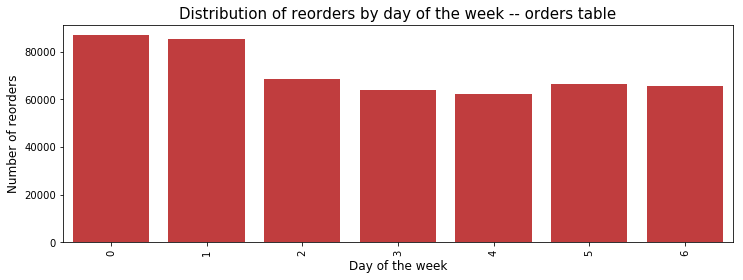

In [31]:
#Now I can start plotting graphs
plt.figure(figsize=(12,4))
sns.countplot(x="order_dow",  data=orders,color=color[3])   
plt.ylabel('Number of reorders', fontsize=12)
plt.xlabel('Day of the week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribution of reorders by day of the week -- orders table", fontsize=15)
plt.show()


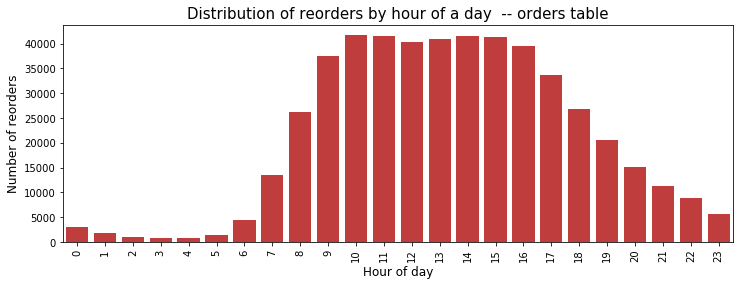

In [32]:
plt.figure(figsize=(12,4))
sns.countplot(x="order_hour_of_day",  data=orders,color=color[3])   
plt.ylabel('Number of reorders', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribution of reorders by hour of a day  -- orders table", fontsize=15)
plt.show()

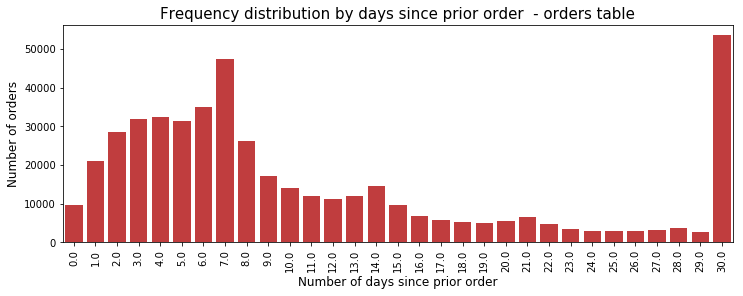

In [33]:
plt.figure(figsize=(12,4))
sns.countplot(x='days_since_prior_order', data=orders, color=color[3])
plt.ylabel('Number of orders', fontsize=12)
plt.xlabel('Number of days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order  - orders table", fontsize=15)
plt.show()

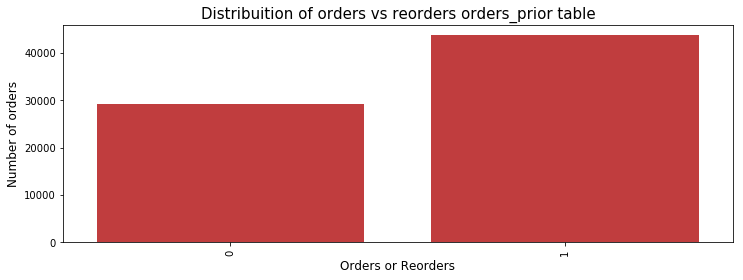

In [34]:
plt.figure(figsize=(12,4))
sns.countplot(x="reordered", data=priorall, color=color[3])
plt.ylabel('Number of orders', fontsize=12)
plt.xlabel('Orders or Reorders', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribuition of orders vs reorders orders_prior table", fontsize=15)
plt.show()

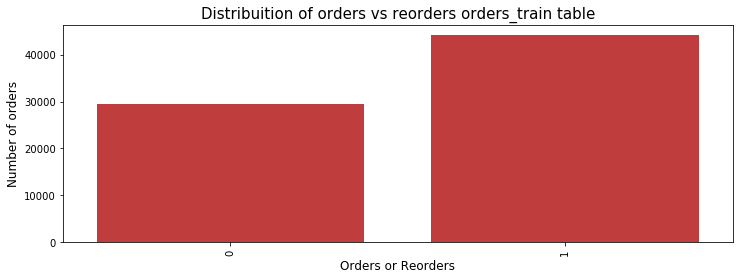

In [35]:
plt.figure(figsize=(12,4))
sns.countplot(x="reordered", data=trainall, color=color[3])
plt.ylabel('Number of orders', fontsize=12)
plt.xlabel('Orders or Reorders', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribuition of orders vs reorders orders_train table", fontsize=15)
plt.show()

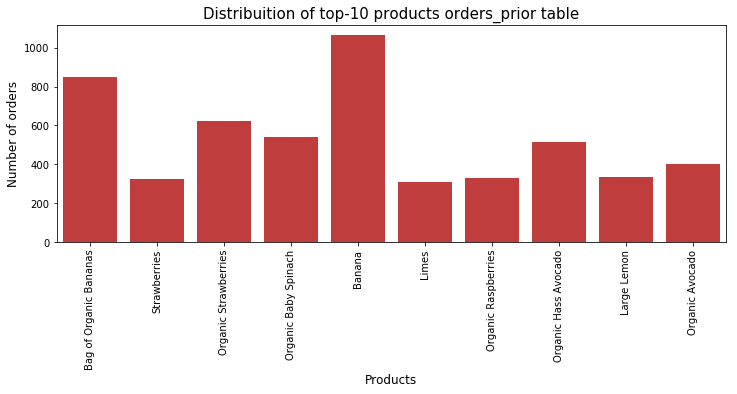

In [36]:
plt.figure(figsize=(12,4))
sns.countplot(x="product_name",data=tmp_4, color=color[3])
plt.ylabel('Number of orders', fontsize=12)
plt.xlabel('Products', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribuition of top-10 products orders_prior table", fontsize=15)
plt.show()

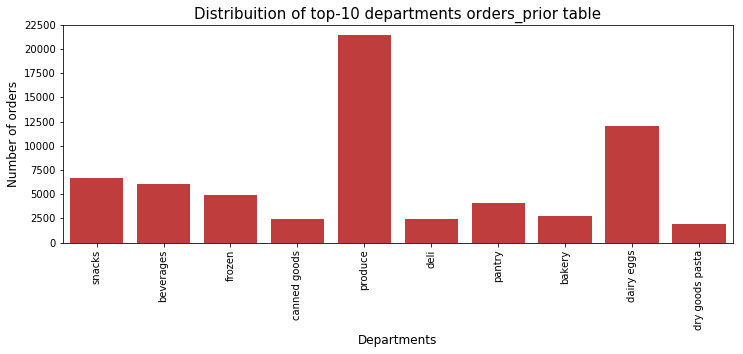

In [37]:
plt.figure(figsize=(12,4))
sns.countplot(x="department", data=tmp_5,color=color[3])
plt.ylabel('Number of orders', fontsize=12)
plt.xlabel('Departments', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribuition of top-10 departments orders_prior table", fontsize=15)
plt.show()

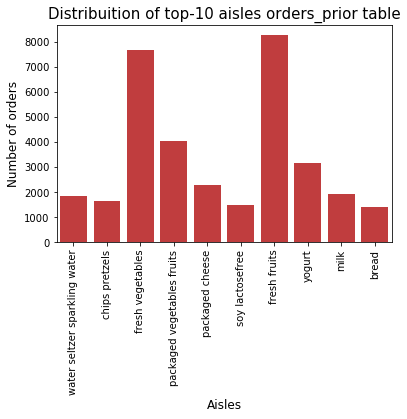

In [38]:
sns.countplot(x="aisle", data=tmp_6,color=color[3])
plt.ylabel('Number of orders', fontsize=12)
plt.xlabel('Aisles', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribuition of top-10 aisles orders_prior table", fontsize=15)
plt.show()

## Distribution of orders on different days of the week per hour 

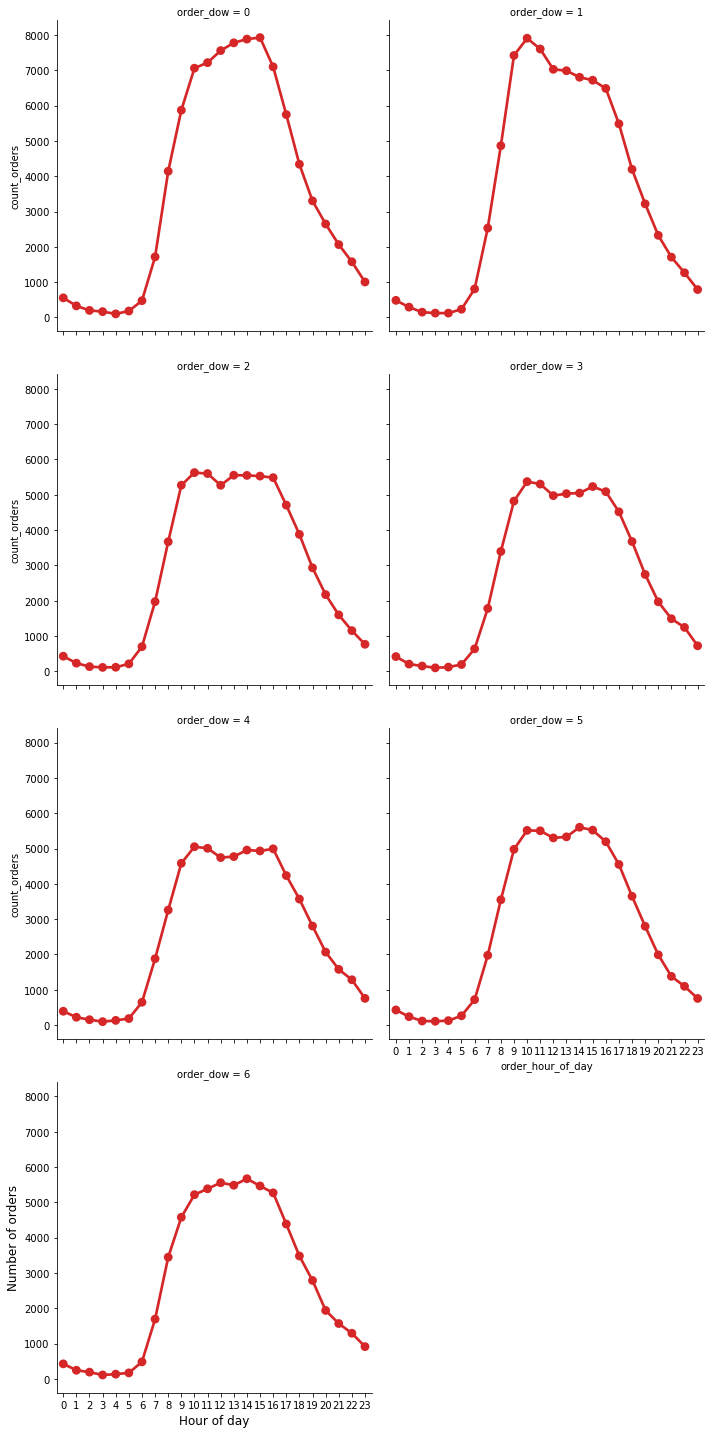

In [39]:
tmp_7 = pd.DataFrame(orders.groupby(['order_dow','order_hour_of_day'])
                          .agg({'order_id':pd.Series.nunique})
                          .rename(columns={'order_id':'count_orders'})).reset_index()
plt.close('all')
sns.factorplot(x="order_hour_of_day", y="count_orders",
               col="order_dow", data=tmp_7, color=color[3],col_wrap=2,size=5);

plt.ylabel('Number of orders', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
#del tmp_1




Most of the purchases are between 9 amp and 17 pm, during office hours, however of the weekend day of week 0 and 1 is a bit different picture, so will have a closer look into it.

## Closer investigation of products re-ordered on Saturday and Sunday (days of week 0 and 1)

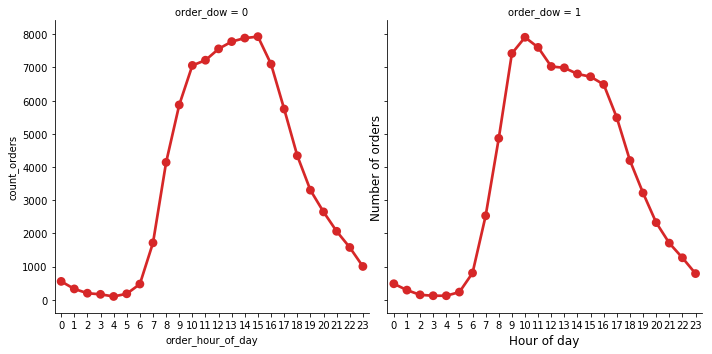

In [40]:
orders_weekend = pd.read_sql_query("SELECT order_id, order_dow,days_since_prior_order,order_hour_of_day\
                            FROM orders WHERE order_dow=0 OR order_dow=1 ;", conn)
tmp_wend = pd.DataFrame(orders_weekend.groupby(['order_dow','order_hour_of_day'])
                          .agg({'order_id':pd.Series.nunique})
                          .rename(columns={'order_id':'count_orders'})).reset_index()
plt.close('all')
sns.factorplot(x="order_hour_of_day", y="count_orders",
               col="order_dow", data=tmp_wend, color=color[3],col_wrap=2,size=5);

plt.ylabel('Number of orders', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)

Number of orders on Saturday steadily increasing since 9 am and drops sharply after 4pm. On Sunday is a bit different picture, number or orders peaks at 10 am and sligtly decreases every hour till 5pm.
Lets have a look which products are most popular purchases on the weekend (according to orders_prior table).

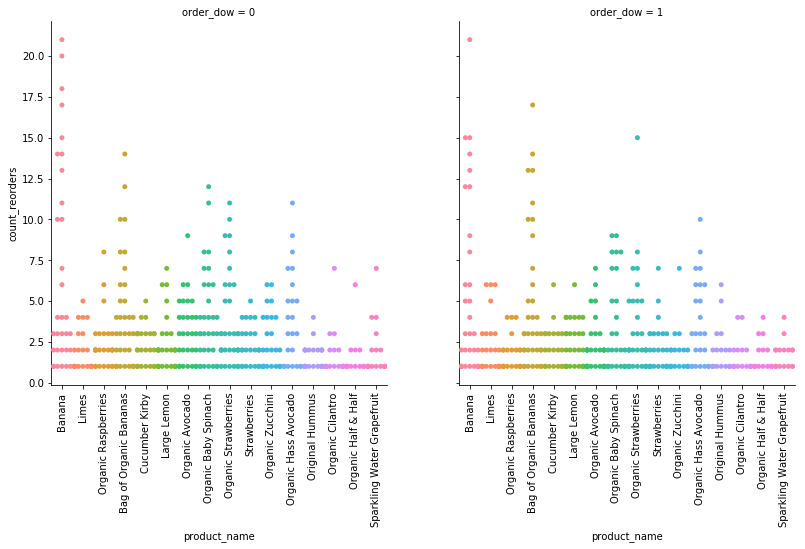

In [41]:
#select only order_dow=0 and order_dow-=1
mergeall_weekend =  pd.read_sql_query("SELECT order_id, order_dow,days_since_prior_order,\
                                    order_hour_of_day,\
                                    product_id, product_name,department, aisle,reordered\
                                    FROM prioralldata\
                                    WHERE order_dow=0 OR order_dow=1;", conn)


tmp_1_groupby= mergeall_weekend.groupby(['order_dow','order_hour_of_day','product_name',
                                         'reordered']).agg({'order_id':
                                                            pd.Series.nunique}).rename(columns={'order_id':
                                                                                                'count_reorders'})
tmp_2_groupby = tmp_1_groupby['count_reorders'].groupby(level=0, group_keys=False)

tmp_8 = pd.DataFrame(tmp_1_groupby).reset_index()
tmp_9 = pd.DataFrame(tmp_2_groupby.nlargest(50)).reset_index()

top10_dayandtime = tmp_9[tmp_9['reordered']==1]


#Limit data to only those products which are in top 10 category by any time and day combination
tmp_8 = tmp_8[tmp_8['product_name'].isin(top10_dayandtime['product_name'])]


#temp_df_01 = temp_df_01[temp_df_01['day_of_week'].isin(['Monday','Tuesday'])] 

#Most orders are between 6 and 20
#temp_df_01 = temp_df_01[(temp_df_01['order_hour_of_day'] >= 6) & (temp_df_01['order_hour_of_day'] <= 20) ]

plt.close('all')
g = sns.factorplot(x='product_name', y='count_reorders',
                   #col="day_of_week", data=temp_df_01[temp_df_01['reordered']==1], kind="swarm",col_wrap=3,size=5);
                   col="order_dow", data=tmp_8, kind="swarm",col_wrap=2,size=6);
g.set_xticklabels(rotation=90)

So, most wanted products on the weekend are fruits and vegetables, and almost all organic produce.

## FEATURE ENGINEERING Creation of new features

Lets have a look at proportion or reorders in relation to the total number of products

In [42]:
user_table = pd.read_sql_query("SELECT * FROM orders WHERE user_id=13 ;", conn)
print("user_id=9694 orders \n", user_table,"\n\n")

user_id=9694 orders 
     index  order_id  user_id eval_set  order_number  order_dow  \
0     104   2618231       13    prior             1          6   
1     105   2560699       13    prior             2          0   
2     106   2288946       13    prior             3          6   
3     107     19256       13    prior             4          1   
4     108   1378982       13    prior             5          0   
5     109   2363981       13    prior             6          0   
6     110   1906169       13    prior             7          0   
7     111   1757094       13    prior             8          6   
8     112    519471       13    prior             9          6   
9     113   2298068       13    prior            10          6   
10    114   1472646       13    prior            11          0   
11    115   1789302       13    prior            12          6   
12    116   1827621       13    train            13          0   

    order_hour_of_day  days_since_prior_order  
0    

In [43]:
user_table = pd.read_sql_query("SELECT * FROM prioralldata WHERE user_id=13 ;", conn)
print("user_id=9694 orders \n", user_table,"\n\n")

user_id=9694 orders 
    index  order_id  user_id eval_set  order_number  order_dow  \
0    107     19256       13    prior             4          1   
1    107     19256       13    prior             4          1   
2    107     19256       13    prior             4          1   
3    107     19256       13    prior             4          1   
4    107     19256       13    prior             4          1   

   order_hour_of_day  days_since_prior_order  product_id  add_to_cart_order  \
0                 12                     9.0       27086                  1   
1                 12                     9.0       27435                  2   
2                 12                     9.0       31372                  4   
3                 12                     9.0       33735                  5   
4                 12                     9.0       41480                  3   

   reordered  product_id:1                   product_name       department  \
0          1         27086        

In [73]:
number_of_reorders = pd.read_sql_query("SELECT COUNT(product_id) FROM prioralldata WHERE reordered=1 ;", conn)
number_of_noorders = pd.read_sql_query("SELECT COUNT(product_id) FROM prioralldata WHERE reordered=0 ;", conn)
proportion_reorders=100*(number_of_reorders/(number_of_reorders+number_of_noorders))
print("proportion of reorders in % is  \n", proportion_reorders,"\n\n")

proportion of reorders in % is  
    COUNT(product_id)
0          60.006309 




So, about 60% of all products have been reordered in every order

## Perform feature selection with SelectKBest and LASSO

In [44]:
priorall.head()

,order_id,order_dow,days_since_prior_order,order_hour_of_day,order_number,add_to_cart_order,product_id,product_name,department,aisle,reordered
0,19989,2,8.0,7,11,1,4122,Chocolate Sandwich Cookies,snacks,cookies cakes,0
1,49629,1,30.0,14,18,1,11119,Chocolate Sandwich Cookies,snacks,cookies cakes,0
2,52768,1,30.0,10,3,1,21054,Chocolate Sandwich Cookies,snacks,cookies cakes,1
3,38944,6,23.0,21,4,6,22561,Chocolate Sandwich Cookies,snacks,cookies cakes,0
4,48889,1,3.0,10,39,2,6268,Sparkling Orange Juice & Prickly Pear Beverage,beverages,water seltzer sparkling water,1


In [45]:
#replace NaN and infinity by the mean value from enron_df only

priorall=priorall.replace([np.inf, -np.inf], np.nan).fillna(orders.mean())
priorall.head()



,order_id,order_dow,days_since_prior_order,order_hour_of_day,order_number,add_to_cart_order,product_id,product_name,department,aisle,reordered
0,19989,2,8.0,7,11,1,4122,Chocolate Sandwich Cookies,snacks,cookies cakes,0
1,49629,1,30.0,14,18,1,11119,Chocolate Sandwich Cookies,snacks,cookies cakes,0
2,52768,1,30.0,10,3,1,21054,Chocolate Sandwich Cookies,snacks,cookies cakes,1
3,38944,6,23.0,21,4,6,22561,Chocolate Sandwich Cookies,snacks,cookies cakes,0
4,48889,1,3.0,10,39,2,6268,Sparkling Orange Juice & Prickly Pear Beverage,beverages,water seltzer sparkling water,1


In [46]:
priorall = priorall.fillna(orders.mean())
priorall.head()


,order_id,order_dow,days_since_prior_order,order_hour_of_day,order_number,add_to_cart_order,product_id,product_name,department,aisle,reordered
0,19989,2,8.0,7,11,1,4122,Chocolate Sandwich Cookies,snacks,cookies cakes,0
1,49629,1,30.0,14,18,1,11119,Chocolate Sandwich Cookies,snacks,cookies cakes,0
2,52768,1,30.0,10,3,1,21054,Chocolate Sandwich Cookies,snacks,cookies cakes,1
3,38944,6,23.0,21,4,6,22561,Chocolate Sandwich Cookies,snacks,cookies cakes,0
4,48889,1,3.0,10,39,2,6268,Sparkling Orange Juice & Prickly Pear Beverage,beverages,water seltzer sparkling water,1


In [47]:
#drop categorical data, only numerical data can go into machine learning algorithms
priorall=priorall.drop('department', axis=1)
priorall=priorall.drop('product_name', axis=1)
priorall=priorall.drop('aisle', axis=1)

priorall_edit=priorall.drop('reordered', axis=1)


priorall_edit.head()

,order_id,order_dow,days_since_prior_order,order_hour_of_day,order_number,add_to_cart_order,product_id
0,19989,2,8.0,7,11,1,4122
1,49629,1,30.0,14,18,1,11119
2,52768,1,30.0,10,3,1,21054
3,38944,6,23.0,21,4,6,22561
4,48889,1,3.0,10,39,2,6268


In [51]:
#create data frame only with product_id for concatenating with testdata which needs product_id numbers for predictions
#weather they were in a next order
test_productid=priorall[['product_id']].copy()
test_productid.head(3)
#test_productid.shape  
# (72909, 1)

,product_id
0,4122
1,11119
2,21054


In [48]:
testdata.head(3)

,order_id,order_dow,days_since_prior_order,order_hour_of_day,order_number
0,2774568,5,11.0,15,13
1,329954,3,30.0,12,6
2,1528013,3,22.0,16,4


In [52]:
testdata.shape

(10931, 5)

In [ ]:
#concatenate 2 tables, so table will have 10931*5847 rows!!!!
#number of unique product_idis     5847
#seems too much! better create separate dataframes (csv files or in sql database) and run each individualy with testdata
#+ 1 single value  #product_id as a new column and run throw selected as best at prediction  machine learning algorithm


In [79]:
priorall.head()

,order_id,order_dow,days_since_prior_order,order_hour_of_day,order_number,add_to_cart_order,product_id,reordered
0,19989,2,8.0,7,11,1,4122,0
1,49629,1,30.0,14,18,1,11119,0
2,52768,1,30.0,10,3,1,21054,1
3,38944,6,23.0,21,4,6,22561,0
4,48889,1,3.0,10,39,2,6268,1


In [80]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


skb = SelectKBest(f_classif,k='all').fit(priorall_edit,priorall['reordered'])
scores = skb.scores_
all_features = priorall.columns.values
sort_index = np.argsort(scores)[::-1]
rank = 1
ranked_features = []
print ("Ranking of features is ")
for x in sort_index:
    print (rank,". Score  ",all_features[x]," is ",scores[x])
    ranked_features.append(all_features[x])
    rank += 1
print (all_features)


Ranking of features is 
1 . Score   order_number  is  7436.76339123
2 . Score   add_to_cart_order  is  1230.39796882
3 . Score   days_since_prior_order  is  1204.20175736
4 . Score   order_hour_of_day  is  48.7814693703
5 . Score   product_id  is  9.06752313378
6 . Score   order_id  is  5.11306880726
7 . Score   order_dow  is  0.389505663797
['order_id' 'order_dow' 'days_since_prior_order' 'order_hour_of_day'
 'order_number' 'add_to_cart_order' 'product_id' 'reordered']


## LASSO

In [81]:
from sklearn.linear_model import Lasso

lasso = Lasso()


lasso_fit=lasso.fit(priorall_edit,priorall['reordered'])

lasso_coef = lasso_fit.coef_

all_features2 = priorall.columns.values
sort_index2 = np.argsort(lasso_coef)[::-1]
rank1 = 1
ranked_features_lasso = []
print ("Ranking of LASSO features is ")
for x in sort_index:
    print (rank1,". Score  ",all_features2[x]," is ",lasso_coef[x])
    ranked_features_lasso.append(all_features2[x])
    rank1 += 1
print (all_features2)

print (lasso_coef)

Ranking of LASSO features is 
1 . Score   order_number  is  0.00523130112728
2 . Score   add_to_cart_order  is  -0.0
3 . Score   days_since_prior_order  is  -0.0
4 . Score   order_hour_of_day  is  -0.0
5 . Score   product_id  is  -3.53015330177e-07
6 . Score   order_id  is  2.56075609104e-07
7 . Score   order_dow  is  -0.0
['order_id' 'order_dow' 'days_since_prior_order' 'order_hour_of_day'
 'order_number' 'add_to_cart_order' 'product_id' 'reordered']
[  2.56075609e-07  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
   5.23130113e-03  -0.00000000e+00  -3.53015330e-07]


Both algorithms for feature selection give pretty much the same result, therefore for my analysis I will choose
first 6 features to predict which products will be reordered.

## Choosing machine learning algorithm

In [82]:
#table for better presentation of results
#Ref : http://stackoverflow.com/questions/30523735/python-dictionary-as-html-table-in-ipython-notebook
class DictTable(dict):
    # Overridden dict class which takes a dict in the form {'a': 2, 'b': 3},
    # and renders an HTML Table in IPython Notebook.
    def _repr_html_(self):
        html = ["<table width=100%>"]
        html.append("<tr>")
        html.append("<th>Classifier</th>")
        html.append("<th>Accuracy</th>")
        html.append("<th>Precision</th>")
        html.append("<th>Recall</th>")
        html.append("</tr>")
        for key, value in self.items():
            html.append("<tr>")
            html.append("<td>{0}</td>".format(key))
            for key_inner,value_inner in value.items():
                html.append("<td>{0}</td>".format(value_inner))
                
           
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

In [83]:
labels = priorall['reordered']
from feature_format import featureFormat, targetFeatureSplit
#from tester import dump_classifier_and_data
import matplotlib.pyplot as plt
from IPython.display import display # Allows the use of display() for DataFrames
import numpy as np
from sklearn import cross_validation
from sklearn.model_selection import StratifiedShuffleSplit,StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import make_scorer
from numpy import mean
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score ,fbeta_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,precision_recall_fscore_support,roc_auc_score
from sklearn.neighbors import KNeighborsClassifier


classifier_dict = {'Logistic Regression':LogisticRegression(random_state = 0,max_iter=500,class_weight='balanced'),
                    'SVM_rbf':SVC(class_weight='balanced',kernel='rbf'),
                   'SVM_sigmoid':SVC(class_weight='balanced',kernel='sigmoid'),
                  'Gaussian Naive Bayes':GaussianNB(),
                  'SVM_linear':LinearSVC(random_state=0,class_weight='balanced'),
                  'Decision Tree':DecisionTreeClassifier(class_weight='balanced',min_samples_split=5),
                  'Random Forest': RandomForestClassifier(n_estimators=100,class_weight='balanced'),
                  'KNN':KNeighborsClassifier()
                  }

In [84]:
from sklearn.pipeline import Pipeline
def get_score_table(features_set,dataset=priorall_edit):
    features = dataset[features_set]
    classifier_comp = {}
    for x in classifier_dict.keys():
        pipeline =  Pipeline(steps=[('scaler', StandardScaler()),
                                         ("classifier",classifier_dict[x])])
        #produces shuffled lots and splits data in 3 parts
        #This cross-validation object is a merge of StratifiedKFold and ShuffleSplit
        #This module creates a single training/testing set having equally balanced(stratified) classes. 
        cv = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
        acc = []
        pre = []
        rec = []
        for train_index, test_index in cv.split(features, labels):
            X_train, X_test = features.iloc[train_index], features.iloc[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
        #    This module is useful as a direct k-fold cross-validation operator: as in it will set up n_folds
        #training/testing sets such that classes are equally balanced in both.
        #cv=StratifiedKFold(n_splits=n_splits).split(enron_data_df[features_5], data_df['poi'])
            pipeline.fit(X_train,y_train)
            predictions = pipeline.predict(X_test)
            acc.append(accuracy_score(predictions,y_test))
            pre.append(precision_score(predictions,y_test))
            rec.append(recall_score(predictions,y_test))
        #print pipeline.named_steps
        classifier_comp[x]={}
        classifier_comp[x]['accuracy']=np.mean(acc)
        classifier_comp[x]['precision']=np.mean(pre)
        classifier_comp[x]['recall']=np.mean(rec)
    return classifier_comp

In [85]:
#Using top 5 features :d
#1 . Score   order_number  is  7436.76339123
#2 . Score   add_to_cart_order  is  1230.39796882
#3 . Score   days_since_prior_order  is  1204.20175736
#4 . Score   order_hour_of_day  is  48.7814693703
#5 . Score   product_id  is  9.06752313378
#6 . Score   order_id  is  5.11306880726

features_6=['order_number', 'add_to_cart_order', 'days_since_prior_order',  'order_hour_of_day','product_id','order_id']
print ("Using Top 6 features")
DictTable(get_score_table(features_6))




Using Top 6 features


Classifier,Accuracy,Precision,Recall
Logistic Regression,0.6439598287081486,0.5601015873015873,0.7849578967290638
SVM_rbf,0.6982428869687135,0.7238603174603174,0.7614877582575289
SVM_sigmoid,0.5778661668114418,0.5758730158730159,0.6733021460203243
Gaussian Naive Bayes,0.6448132400676633,0.7484952380952382,0.6873790057401367
SVM_linear,0.6370411009006537,0.5414349206349206,0.7872649635405348
Decision Tree,0.7155854249531387,0.7363047619047619,0.7778481343055672
Random Forest,0.7654185525533762,0.8372571428571428,0.7858539594296855
KNN,0.7433822520916197,0.8233142857142856,0.7663866110063716


Pretty good results from first attempt! OK, let have a closer look into Random Forest and use it as a final classifier to predict
which producst will be in the next customer's order.
Params that we used are 'Random Forest': RandomForestClassifier(n_estimators=100,class_weight='balanced'),

## Tuning Random Forest as a best classifier.

Firstly, I test Number of trees in the forest (n_estimators)
This is the number of trees I want to build before taking the maximum voting or averages of predictions. Higher number of trees give me better performance but makes your code slower. I should choose as high value as your processor can handle because this makes your predictions stronger and more stable

In [74]:
classifier_dict2 = {'Random Forest n=120': RandomForestClassifier(n_estimators=120,class_weight='balanced'),
                    'Random Forest n=300': RandomForestClassifier(n_estimators=300,class_weight='balanced'),
                    'Random Forest n=500': RandomForestClassifier(n_estimators=500,class_weight='balanced'),
                    'Random Forest n=800': RandomForestClassifier(n_estimators=800,class_weight='balanced'),
                    'Random Forest n=1200': RandomForestClassifier(n_estimators=1200,class_weight='balanced'),
                    }

def get_score_table2(features_set,dataset=priorall_edit):
    features = dataset[features_set]
    classifier_comp = {}
    for x in classifier_dict2.keys():
        pipeline =  Pipeline(steps=[('scaler', StandardScaler()),
                                         ("classifier",classifier_dict2[x])])
        #produces shuffled lots and splits data in 3 parts
        #This cross-validation object is a merge of StratifiedKFold and ShuffleSplit
        #This module creates a single training/testing set having equally balanced(stratified) classes. 
        cv = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
        acc = []
        pre = []
        rec = []
        for train_index, test_index in cv.split(features, labels):
            X_train, X_test = features.iloc[train_index], features.iloc[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
        #    This module is useful as a direct k-fold cross-validation operator: as in it will set up n_folds
        #training/testing sets such that classes are equally balanced in both.
        #cv=StratifiedKFold(n_splits=n_splits).split(enron_data_df[features_5], data_df['poi'])
            pipeline.fit(X_train,y_train)
            predictions = pipeline.predict(X_test)
            acc.append(accuracy_score(predictions,y_test))
            pre.append(precision_score(predictions,y_test))
            rec.append(recall_score(predictions,y_test))
        #print pipeline.named_steps
        classifier_comp[x]={}
        classifier_comp[x]['accuracy']=np.mean(acc)
        classifier_comp[x]['precision']=np.mean(pre)
        classifier_comp[x]['recall']=np.mean(rec)
    return classifier_comp



#start_time5 = datetime.now()
features_6=['order_number', 'add_to_cart_order', 'days_since_prior_order',  'order_hour_of_day','product_id','order_id']
print ("Using Top 6 features Same parameters as in algorithm selection")
DictTable(get_score_table2(features_6))
#end_time5=datatime.now()
#print('\nProcessing time {}\n'.format((end_time5-start_time5).total_seconds()))

Using Top 6 features Same parameters as in algorithm selection


Classifier,Accuracy,Precision,Recall
Random Forest n=120,0.766607232661272,0.8380698412698413,0.7868648798630589
Random Forest n=300,0.76621100595864,0.8394666666666666,0.7856425507124124
Random Forest n=500,0.7662262454472027,0.8394666666666666,0.7856592455324826
Random Forest n=800,0.7666224721498347,0.8404063492063493,0.7856414193885933
Random Forest n=1200,0.766470077264207,0.8402031746031747,0.7855583740735758


Ok, looks like by increasing number of trees quality of clasification is slightly better, but runs slower 
Secondly, I set n_estimators=1200 and test maximum depth of tree (max_depth).  If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

In [75]:
classifier_dict3 = {'Random Forest mdepth=5': RandomForestClassifier(n_estimators=120, max_depth=5, class_weight='balanced'),
                    'Random Forest mdepth=8': RandomForestClassifier(n_estimators=120,max_depth=8,class_weight='balanced'),
                    'Random Forest mdepth=15': RandomForestClassifier(n_estimators=120,max_depth=15,class_weight='balanced'),
                    'Random Forest mdepth=25': RandomForestClassifier(n_estimators=120,max_depth=25,class_weight='balanced'),
                    'Random Forest mdepth=30': RandomForestClassifier(n_estimators=120,max_depth=30,class_weight='balanced'),
                    'Random Forest mdepth=None': RandomForestClassifier(n_estimators=120,max_depth=None,class_weight='balanced'),
                    }

def get_score_table3(features_set,dataset=priorall_edit):
    features = dataset[features_set]
    classifier_comp = {}
    for x in classifier_dict3.keys():
        pipeline =  Pipeline(steps=[('scaler', StandardScaler()),
                                         ("classifier",classifier_dict3[x])])
        #produces shuffled lots and splits data in 3 parts
        #This cross-validation object is a merge of StratifiedKFold and ShuffleSplit
        #This module creates a single training/testing set having equally balanced(stratified) classes. 
        cv = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
        acc = []
        pre = []
        rec = []
        for train_index, test_index in cv.split(features, labels):
            X_train, X_test = features.iloc[train_index], features.iloc[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
        #    This module is useful as a direct k-fold cross-validation operator: as in it will set up n_folds
        #training/testing sets such that classes are equally balanced in both.
        #cv=StratifiedKFold(n_splits=n_splits).split(enron_data_df[features_5], data_df['poi'])
            pipeline.fit(X_train,y_train)
            predictions = pipeline.predict(X_test)
            acc.append(accuracy_score(predictions,y_test))
            pre.append(precision_score(predictions,y_test))
            rec.append(recall_score(predictions,y_test))
        #print pipeline.named_steps
        classifier_comp[x]={}
        classifier_comp[x]['accuracy']=np.mean(acc)
        classifier_comp[x]['precision']=np.mean(pre)
        classifier_comp[x]['recall']=np.mean(rec)
    return classifier_comp



#start_time5 = datetime.now()
features_6=['order_number', 'add_to_cart_order', 'days_since_prior_order',  'order_hour_of_day','product_id','order_id']
print ("Using Top 6 features Same parameters as in algorithm selection")
DictTable(get_score_table3(features_6))

Using Top 6 features Same parameters as in algorithm selection


Classifier,Accuracy,Precision,Recall
Random Forest mdepth=5,0.7102973224218596,0.7932190476190476,0.7418639962879919
Random Forest mdepth=8,0.7184047303372498,0.788063492063492,0.7538924167178479
Random Forest mdepth=15,0.7636202929029702,0.8465015873015873,0.7788281409774935
Random Forest mdepth=25,0.7671406147609687,0.8445460317460318,0.7840784944732109
Random Forest mdepth=30,0.7666529511269603,0.8408888888888889,0.7854255771220656
Random Forest mdepth=None,0.7666681906155229,0.8382222222222223,0.7868641455404908


mdepth=25 gives the best performance so far, a much higher precision in comparison to previous tests.

Next, I will test the minimum number of samples required to split an internal node (min_samples_split)

Default min_samples_split=2


In [76]:
classifier_dict4 = {'Random Forest min_samples_split=2': RandomForestClassifier(n_estimators=120,max_depth=25,\
                                                                    min_samples_split=2, class_weight='balanced'),
                    'Random Forest min_samples_split=5': RandomForestClassifier(n_estimators=120,max_depth=25,\
                                                                     min_samples_split=5, class_weight='balanced'),
                    'Random Forest min_samples_split=10': RandomForestClassifier(n_estimators=120,max_depth=25,\
                                                                     min_samples_split=10, class_weight='balanced'),
                    'Random Forest min_samples_split=15': RandomForestClassifier(n_estimators=120,max_depth=25,\
                                                                     min_samples_split=15, class_weight='balanced'),
                    'Random Forest min_samples_split=100': RandomForestClassifier(n_estimators=120,max_depth=25,\
                                                                     min_samples_split=100, class_weight='balanced'),
                    }

def get_score_table4(features_set,dataset=priorall_edit):
    features = dataset[features_set]
    classifier_comp = {}
    for x in classifier_dict4.keys():
        pipeline =  Pipeline(steps=[('scaler', StandardScaler()),
                                         ("classifier",classifier_dict4[x])])
        #produces shuffled lots and splits data in 3 parts
        #This cross-validation object is a merge of StratifiedKFold and ShuffleSplit
        #This module creates a single training/testing set having equally balanced(stratified) classes. 
        cv = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
        acc = []
        pre = []
        rec = []
        for train_index, test_index in cv.split(features, labels):
            X_train, X_test = features.iloc[train_index], features.iloc[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
        #    This module is useful as a direct k-fold cross-validation operator: as in it will set up n_folds
        #training/testing sets such that classes are equally balanced in both.
        #cv=StratifiedKFold(n_splits=n_splits).split(enron_data_df[features_5], data_df['poi'])
            pipeline.fit(X_train,y_train)
            predictions = pipeline.predict(X_test)
            acc.append(accuracy_score(predictions,y_test))
            pre.append(precision_score(predictions,y_test))
            rec.append(recall_score(predictions,y_test))
        #print pipeline.named_steps
        classifier_comp[x]={}
        classifier_comp[x]['accuracy']=np.mean(acc)
        classifier_comp[x]['precision']=np.mean(pre)
        classifier_comp[x]['recall']=np.mean(rec)
    return classifier_comp



#start_time5 = datetime.now()
features_6=['order_number', 'add_to_cart_order', 'days_since_prior_order',  'order_hour_of_day','product_id','order_id']
print ("Using Top 6 features Same parameters as in algorithm selection")
DictTable(get_score_table4(features_6))

Using Top 6 features Same parameters as in algorithm selection


Classifier,Accuracy,Precision,Recall
Random Forest min_samples_split=2,0.7669729803867783,0.8447746031746032,0.7837509008744549
Random Forest min_samples_split=5,0.7722458434294944,0.8390603174603175,0.793338747097352
Random Forest min_samples_split=10,0.7704475837790884,0.8335746031746032,0.7941304784359646
Random Forest min_samples_split=15,0.767445404532224,0.8285714285714286,0.793168266461104
Random Forest min_samples_split=100,0.7354729575275454,0.7978412698412698,0.7697803252946519


min_samples_split=2 gives better result!
Next I will test the max_leaf_nodes
(max_leaf_nodes) Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity.
If None then unlimited number of leaf nodes.

In [77]:
classifier_dict5 = {'Random Forest max_leaf_nodes=2': RandomForestClassifier(n_estimators=120,max_depth=25,max_leaf_nodes=2,\
                                                                    min_samples_split=2, class_weight='balanced'),
                    'Random Forest max_leaf_nodes=5': RandomForestClassifier(n_estimators=120,max_depth=25,max_leaf_nodes=5,\
                                                                     min_samples_split=2, class_weight='balanced'),
                    'Random Forest max_leaf_nodes=10': RandomForestClassifier(n_estimators=120,max_depth=25,max_leaf_nodes=10,\
                                                                     min_samples_split=2, class_weight='balanced'),
                    'Random Forest max_leaf_nodes=None': RandomForestClassifier(n_estimators=120,max_depth=25,\
                                                                     min_samples_split=2, class_weight='balanced'),          
                    }

def get_score_table5(features_set,dataset=priorall_edit):
    features = dataset[features_set]
    classifier_comp = {}
    for x in classifier_dict5.keys():
        pipeline =  Pipeline(steps=[('scaler', StandardScaler()),
                                         ("classifier",classifier_dict5[x])])
        #produces shuffled lots and splits data in 3 parts
        #This cross-validation object is a merge of StratifiedKFold and ShuffleSplit
        #This module creates a single training/testing set having equally balanced(stratified) classes. 
        cv = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
        acc = []
        pre = []
        rec = []
        for train_index, test_index in cv.split(features, labels):
            X_train, X_test = features.iloc[train_index], features.iloc[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
        #    This module is useful as a direct k-fold cross-validation operator: as in it will set up n_folds
        #training/testing sets such that classes are equally balanced in both.
        #cv=StratifiedKFold(n_splits=n_splits).split(enron_data_df[features_5], data_df['poi'])
            pipeline.fit(X_train,y_train)
            predictions = pipeline.predict(X_test)
            acc.append(accuracy_score(predictions,y_test))
            pre.append(precision_score(predictions,y_test))
            rec.append(recall_score(predictions,y_test))
        #print pipeline.named_steps
        classifier_comp[x]={}
        classifier_comp[x]['accuracy']=np.mean(acc)
        classifier_comp[x]['precision']=np.mean(pre)
        classifier_comp[x]['recall']=np.mean(rec)
    return classifier_comp



#start_time5 = datetime.now()
features_6=['order_number', 'add_to_cart_order', 'days_since_prior_order',  'order_hour_of_day','product_id','order_id']
print ("Using Top 6 features Same parameters as in algorithm selection")
DictTable(get_score_table5(features_6))

Using Top 6 features Same parameters as in algorithm selection


Classifier,Accuracy,Precision,Recall
Random Forest max_leaf_nodes=2,0.6877733583260945,0.7655619047619048,0.7282022166829748
Random Forest max_leaf_nodes=5,0.7050701778448315,0.8042666666666666,0.7311272746860679
Random Forest max_leaf_nodes=10,0.7061826605099134,0.7988825396825397,0.7346764779794865
Random Forest max_leaf_nodes=None,0.7677197153263536,0.8442412698412699,0.784948963061194


Ok, it is better not to specify max_lead_nodes.

Lastly, I will test max_features 
The number of features to consider when looking for the best split:
If int, then consider max_features features at each split.
If float, then max_features is a percentage and int(max_features * n_features) features are considered at each split.
If “auto”, then max_features=sqrt(n_features).
If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
If “log2”, then max_features=log2(n_features).
If None, then max_features=n_features.
Note: the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.

In [78]:
classifier_dict6 = {'Random Forest max_features=log2': RandomForestClassifier(n_estimators=120,max_depth=25,max_features='log2',\
                                                                    min_samples_split=2, class_weight='balanced'),
                    'Random Forest max_features=sqrt': RandomForestClassifier(n_estimators=120,max_depth=25,max_features='auto',\
                                                                     min_samples_split=2, class_weight='balanced'),
                    'Random Forest max_feautures None': RandomForestClassifier(n_estimators=120,max_depth=25,\
                                                                     min_samples_split=2, class_weight='balanced'),
                    }

def get_score_table6(features_set,dataset=priorall_edit):
    features = dataset[features_set]
    classifier_comp = {}
    for x in classifier_dict6.keys():
        pipeline =  Pipeline(steps=[('scaler', StandardScaler()),
                                         ("classifier",classifier_dict6[x])])
        #produces shuffled lots and splits data in 3 parts
        #This cross-validation object is a merge of StratifiedKFold and ShuffleSplit
        #This module creates a single training/testing set having equally balanced(stratified) classes. 
        cv = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
        acc = []
        pre = []
        rec = []
        for train_index, test_index in cv.split(features, labels):
            X_train, X_test = features.iloc[train_index], features.iloc[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
        #    This module is useful as a direct k-fold cross-validation operator: as in it will set up n_folds
        #training/testing sets such that classes are equally balanced in both.
        #cv=StratifiedKFold(n_splits=n_splits).split(enron_data_df[features_5], data_df['poi'])
            pipeline.fit(X_train,y_train)
            predictions = pipeline.predict(X_test)
            acc.append(accuracy_score(predictions,y_test))
            pre.append(precision_score(predictions,y_test))
            rec.append(recall_score(predictions,y_test))
        #print pipeline.named_steps
        classifier_comp[x]={}
        classifier_comp[x]['accuracy']=np.mean(acc)
        classifier_comp[x]['precision']=np.mean(pre)
        classifier_comp[x]['recall']=np.mean(rec)
    return classifier_comp



#start_time5 = datetime.now()
features_6=['order_number', 'add_to_cart_order', 'days_since_prior_order',  'order_hour_of_day','product_id','order_id']
print ("Using Top 6 features Same parameters as in algorithm selection")
DictTable(get_score_table6(features_6))

Using Top 6 features Same parameters as in algorithm selection


Classifier,Accuracy,Precision,Recall
Random Forest max_features=log2,0.7672320516923453,0.8444444444444444,0.7842344308794624
Random Forest max_features=sqrt,0.7674606440207867,0.8446984126984128,0.7843893213390736
Random Forest max_feautures None,0.7679330681662323,0.8450031746031748,0.7848052736403898


Ok, now I can finalize all parameter for Random Forest


In [101]:
import utils
classifier_dict7 = {'Random Forest finalized params': RandomForestClassifier(n_estimators=1200,max_depth=25,max_features='log2',\
                                                                    min_samples_split=2, class_weight='balanced'),
                    }

def get_score_table7(features_set,dataset=priorall_edit):
    features = dataset[features_set]
    classifier_comp = {}
    for x in classifier_dict7.keys():
        pipeline =  Pipeline(steps=[('scaler', StandardScaler()),
                                         ("classifier",classifier_dict7[x])])
        #produces shuffled lots and splits data in 3 parts
        #This cross-validation object is a merge of StratifiedKFold and ShuffleSplit
        #This module creates a single training/testing set having equally balanced(stratified) classes. 
        cv = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
        acc = []
        pre = []
        rec = []
        for train_index, test_index in cv.split(features, labels):
            X_train, X_test = features.iloc[train_index], features.iloc[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
        #    This module is useful as a direct k-fold cross-validation operator: as in it will set up n_folds
        #training/testing sets such that classes are equally balanced in both.
        #cv=StratifiedKFold(n_splits=n_splits).split(enron_data_df[features_5], data_df['poi'])
            pipeline.fit(X_train,y_train)
            predictions = pipeline.predict(X_test)
            acc.append(accuracy_score(predictions,y_test))
            pre.append(precision_score(predictions,y_test))
            rec.append(recall_score(predictions,y_test))
           #print pipeline.named_steps
        classifier_comp[x]={}
        classifier_comp[x]['accuracy']=np.mean(acc)
        classifier_comp[x]['precision']=np.mean(pre)
        classifier_comp[x]['recall']=np.mean(rec)
    return classifier_comp



#start_time5 = datetime.now()
features_6=['order_number', 'add_to_cart_order', 'days_since_prior_order',  'order_hour_of_day','product_id','order_id']
print ("Using Top 6 features Same parameters as in algorithm selection")
DictTable(get_score_table7(features_6))


Using Top 6 features Same parameters as in algorithm selection


Classifier,Accuracy,Precision,Recall
Random Forest finalized params,0.7674301650436611,0.8453079365079366,0.7840324705106955


OK, now I will compare results with data with no feature 'add_to_cart_order' and 'product_id' specified, as we do not have this information
in our test set data


In [87]:
#start_time5 = datetime.now()
features_5=['order_number', 'days_since_prior_order',  'order_hour_of_day','order_id','order_dow']
print ("comparison with available features in test set")
DictTable(get_score_table7(features_5))

comparison with available features in test set


Classifier,Accuracy,Precision,Recall
Random Forest finalized params,0.7203553848732837,0.7433650793650793,0.7802311899357788


Ok, this is actually pretty good result, so this model could be used for prediction.
The final accuracy of the best result is 0.7674.
In order to work out which products will be bought in which order I need to create 5847 (number of unique product_id)
tables/dataframes with 10931 (total number of test unique order_id) rows as datasets for predictions that I needed for kaggle submission.
